# Reading Raster Data using RasterFrames

RasterFrames は洗練された計算およびアルゴリズム機能を、一般のコンピューティング関係者が親しみやすくアクセスしやすい表形式で提供できます。Apache Spark 上に構築されているため、ローカルマシン上でプロトタイプ化されたソリューションを簡単にスケーリングして、クラスターおよびクラウド コンピューティング リソースで実行できます。

[RasterFrame Functions](https://rasterframes.io/reference.html) は、200 以上のラスター関数とベクトル関数によるフィルタリング、変換、サマライズ、再サンプリング、ラスタライズが可能です。

## 環境構築

<br>

1. 新規にクラスターを **Runtime 7.3 LTS (includes Apache Spark 3.0.1, Scala 2.12)** で作成します。
1. **Install GDAL Native Library**<br>
この[ノートブック](https://github.com/nohanaga/databricks-geotools/blob/main/Geo_Exercise0_Setup_GeoTools.ipynb)の説明に従って、[init スクリプト](https://docs.databricks.com/clusters/init-scripts.html#cluster-scoped-init-scripts)を作成し、登録します。
    - `dbfs:/FileStore/gdal/gdal_install.sh`
1. **Install RasterFrames on the Cluster**<br>
以下の .jar/.whl ファイルを[こちら](https://github.com/nohanaga/rasterframes/releases/tag/0.10.2-db)からダウンロードし、[ライブラリ UI](https://docs.databricks.com/libraries/index.html)から登録してください。アップロードは、UIからドラッグ＆ドロップで行うことができます。
    - JAR: pyrasterframes-assembly-0.10.2-dbr10.jar
    - JAR: pyrasterframes_2.12-0.10.2-dbr10.jar
    - Python Whl: pyrasterframes-0.10.2.dev0+dbr10-py3-none-any.whl
1. **オプションで Rasterframes が[推奨](https://rasterframes.io/getting-started.html)する [Spark configs](https://docs.databricks.com/clusters/configure.html#spark-configuration) を設定します**<br>
    - spark.serializer org.apache.spark.serializer.KryoSerializer
    - spark.kryo.registrator org.locationtech.rasterframes.util.RFKryoRegistrator
    - spark.kryoserializer.buffer.max 500m
1. **クラスターを再起動します**

## Reading Cloud Optimized GeoTIFF

In [0]:
from pyrasterframes import *
from pyrasterframes.utils import create_rf_spark_session
from pyrasterframes import rf_ipython
from pyspark.sql.functions import lit 
from pyrasterframes.rasterfunctions import *
from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt

spark = create_rf_spark_session()

Showing only top 5 rows 
 
 proj_raster_path proj_raster_b0 proj_raster_b1 proj_raster_b2 proj_raster_b3 
 
 
 /dbfs/mnt/testblob2/sentinel_4band_cog.tif 
 /dbfs/mnt/testblob2/sentinel_4band_cog.tif 
 /dbfs/mnt/testblob2/sentinel_4band_cog.tif 
 /dbfs/mnt/testblob2/sentinel_4band_cog.tif 
 /dbfs/mnt/testblob2/sentinel_4band_cog.tif
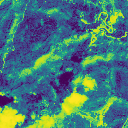
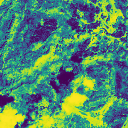
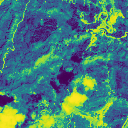
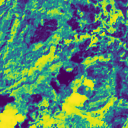
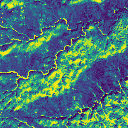
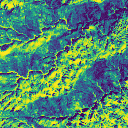
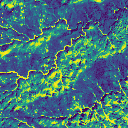
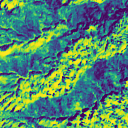
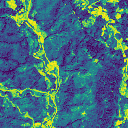
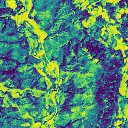
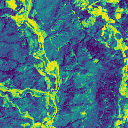
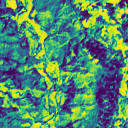
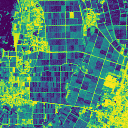
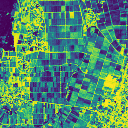
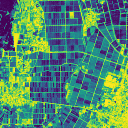
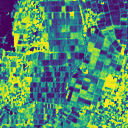
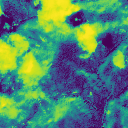
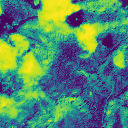
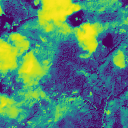
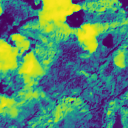

In [0]:
mb = spark.read.raster(
    '/dbfs/mnt/testblob/sentinel_4band_cog.tif',
    band_indexes=[0, 1, 2, 3],
)
mb.cache()

上記のアドレスにあるファイルは、RasterFrames が完全にサポートする有効な [Cloud Optimized GeoTIFF (COG)](https://www.cogeo.org/)です。RasterFrame は、COG 形式の最適化を利用して、非 COG GeoTIFF と比較してより効率的な読み取りを可能にします。


`proj_raster_b0` 列を開梱して、内容を詳しく見てみましょう。これには、CRS、その CRS で測定された空間範囲、および `tile` と呼ばれる数値の 2 次元配列が含まれます。

In [0]:
crs = mb.select(rf_crs("proj_raster_b0").alias("value")).first()
print("CRS", crs.value.crsProj4)

CRS +proj=utm +zone=54 +datum=WGS84 +units=m +no_defs

In [0]:
#データのスキーマ
mb.printSchema()

root
-- proj_raster_path: string (nullable = false)
-- proj_raster_b0: struct (nullable = true)
 |-- tile: tile (nullable = true)
 |-- extent: struct (nullable = true)
 | |-- xmin: double (nullable = true)
 | |-- ymin: double (nullable = true)
 | |-- xmax: double (nullable = true)
 | |-- ymax: double (nullable = true)
 |-- crs: crs (nullable = true)
-- proj_raster_b1: struct (nullable = true)
 |-- tile: tile (nullable = true)
 |-- extent: struct (nullable = true)
 | |-- xmin: double (nullable = true)
 | |-- ymin: double (nullable = true)
 | |-- xmax: double (nullable = true)
 | |-- ymax: double (nullable = true)
 |-- crs: crs (nullable = true)
-- proj_raster_b2: struct (nullable = true)
 |-- tile: tile (nullable = true)
 |-- extent: struct (nullable = true)
 | |-- xmin: double (nullable = true)
 | |-- ymin: double (nullable = true)
 | |-- xmax: double (nullable = true)
 | |-- ymax: double (nullable = true)
 |-- crs: crs (nullable = true)
-- proj_raster_b3: struct (nullable = true)
 |-- tile: tile (nullable = true)
 |-- extent: struct (nullable = true)
 | |-- xmin: double (nullable = true)
 | |-- ymin: double (nullable = true)
 | |-- xmax: double (nullable = true)
 | |-- ymax: double (nullable = true)
 |-- crs: crs (nullable = true)

In [0]:
#タイルの総数
mb.count()

Out[7]: 1849

In [0]:
#パーティンションの総数
mb.rdd.getNumPartitions()

Out[8]: 200

単一のラスターが、重複しない任意の領域を含む多くの行に分割されていることもわかります。これにより、クラウドでホストされているデータ ソースからの並列メモリ内読み取りを利用して、Spark が行ごとに管理可能な量のデータを処理できるようになります。以下のマップは、個々のタイルの境界を含むダウンサンプリングされた画像を示しています

Showing only top 5 rows 
 
 extent tile 
 
 
 [302560.0, 4097600.0, 305120.0, 4100160.0] 
 [369120.0, 4194880.0, 371680.0, 4197440.0] 
 [392160.0, 4171840.0, 394720.0, 4174400.0] 
 [394720.0, 4146240.0, 397280.0, 4148800.0] 
 [353760.0, 4143680.0, 356320.0, 4146240.0]
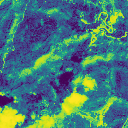
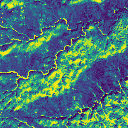
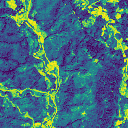
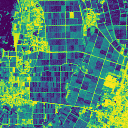
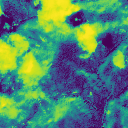

In [0]:
mb.select(
    rf_extent("proj_raster_b0").alias("extent"),
    rf_tile("proj_raster_b0").alias("tile")
)

タイルを1つ選択して表示してみましょう。タイルのプレビュー画像と文字列表現には、タイルの基本的な情報、すなわち、列と行の数としての寸法と、タイル内のすべてのセルのセルタイプ（データ型）が示されています。セルタイプについては、[こちら](https://rasterframes.io/nodata-handling.html#cell-types)を参照してください。


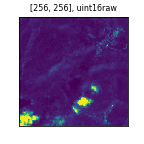

In [0]:
tile = mb.select(rf_tile("proj_raster_b0")).first()[0]
tile

## カラム名の変更

Showing only top 5 rows 
 
 proj_raster_path blue green red nir 
 
 
 /dbfs/mnt/testblob2/sentinel_4band_cog.tif 
 /dbfs/mnt/testblob2/sentinel_4band_cog.tif 
 /dbfs/mnt/testblob2/sentinel_4band_cog.tif 
 /dbfs/mnt/testblob2/sentinel_4band_cog.tif 
 /dbfs/mnt/testblob2/sentinel_4band_cog.tif
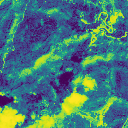
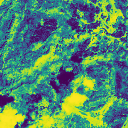
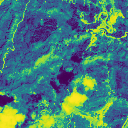
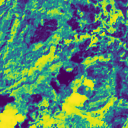
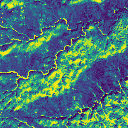
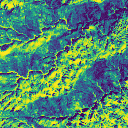
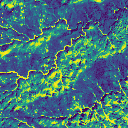
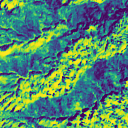
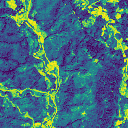
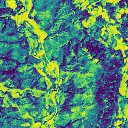
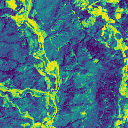
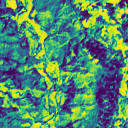
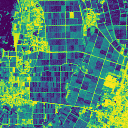
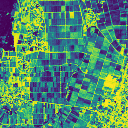
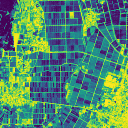
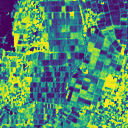
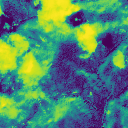
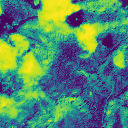
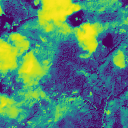
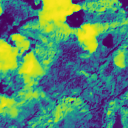

In [0]:
# Adding semantic names 
mb = mb.withColumnRenamed('proj_raster_b0', 'blue') \
.withColumnRenamed('proj_raster_b1', 'green') \
.withColumnRenamed('proj_raster_b2', 'red') \
.withColumnRenamed('proj_raster_b3', 'nir')
mb

## NDVI の計算
GeoTIFF 形式の Sentinel-2 画像（赤と近赤外線）の 2 つのバンドを読み込み、正規化差植生指数（NDVI）と組み合わせます。下のサンプルでは、このデータを使用して、南魚沼市の植生状況を評価しています。RasterFrame コンテンツの操作には rf_ipython モジュールを使い、下に示すように、赤（red）、近赤外線（NIR）、正規化差植生指数（NDVI）のそれぞれの色調に応じた表示が行えるようになっています。

`rf_normalized_difference` は 2 つのタイルの正規化された差: `(tile1 - tile2) / (tile1 + tile2)` を計算します。結果は常に浮動小数点セル型です。この関数にはスカラ型はありません。

Showing only top 5 rows 
 
 proj_raster_path blue green red nir ndvi 
 
 
 /dbfs/mnt/testblob2/sentinel_4band_cog.tif 
 /dbfs/mnt/testblob2/sentinel_4band_cog.tif 
 /dbfs/mnt/testblob2/sentinel_4band_cog.tif 
 /dbfs/mnt/testblob2/sentinel_4band_cog.tif 
 /dbfs/mnt/testblob2/sentinel_4band_cog.tif
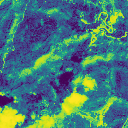
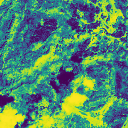
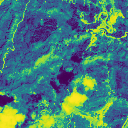
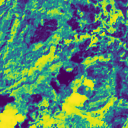
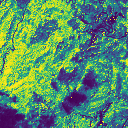
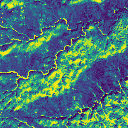
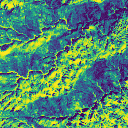
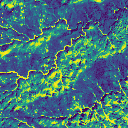
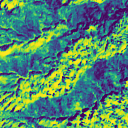
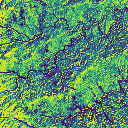
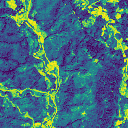
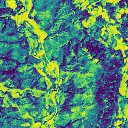
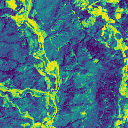
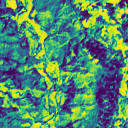
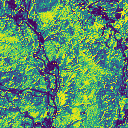
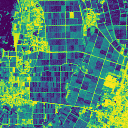
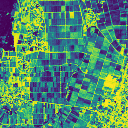
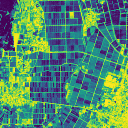
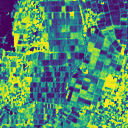
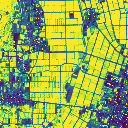
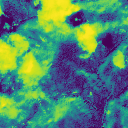
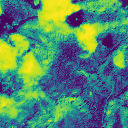
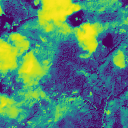
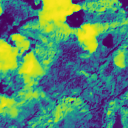
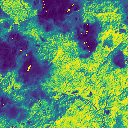

In [0]:
mb = mb.withColumn('ndvi', rf_normalized_difference('nir', 'red'))
mb

## 座標変換
投影座標への変換を行って、タイルの中心点を参照用に追加する

In [0]:
mb = mb.withColumn('lon_lat', st_reproject(st_centroid(rf_geometry('red')), rf_crs('red'), lit('EPSG:4326')))

## 新しい列の選択と作成

`select()` は指定したカラム名で新しい DataFrame を返します。

Showing only top 5 rows 
 
 lon_lat blue green red nir ndvi 
 
 
 POINT (138.79506171703105 37.01563676574... 
 POINT (139.52583811390693 37.90374690414... 
 POINT (139.7912404607241 37.699119650377... 
 POINT (139.8239094709403 37.468716051877... 
 POINT (139.36136307942377 37.44013344547...
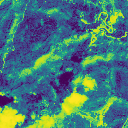
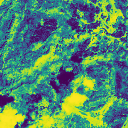
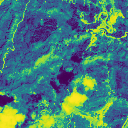
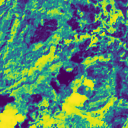
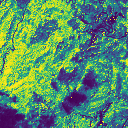
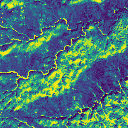
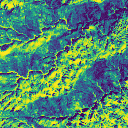
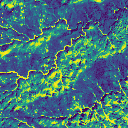
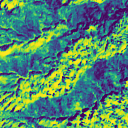
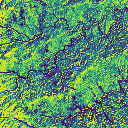
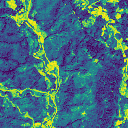
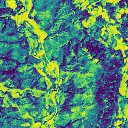
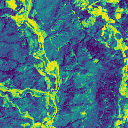
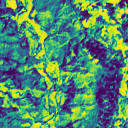
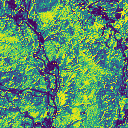
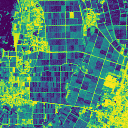
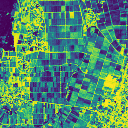
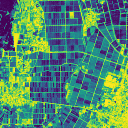
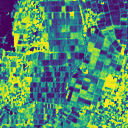
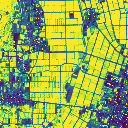
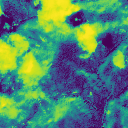
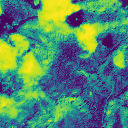
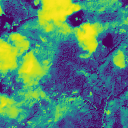
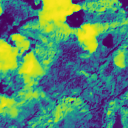
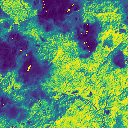

In [0]:
mb.select('lon_lat', 'blue', 'green', 'red', 'nir', 'ndvi')

## PNG への変換
3 つのタイル列を 3 チャンネルの PNG エンコードイメージバイト配列に変換します。まず、与えられたタイルの列に対して `rf_rgb_composite` を評価し、その結果をエンコードします。

Showing only top 5 rows 
 
 proj_raster_path blue green red nir ndvi lon_lat rgb 
 
 
 /dbfs/mnt/testblob2/sentinel_4band_cog.tif POINT (138.79506171703105 37.01563676574... 
 /dbfs/mnt/testblob2/sentinel_4band_cog.tif POINT (139.52583811390693 37.90374690414... 
 /dbfs/mnt/testblob2/sentinel_4band_cog.tif POINT (139.7912404607241 37.699119650377... 
 /dbfs/mnt/testblob2/sentinel_4band_cog.tif POINT (139.8239094709403 37.468716051877... 
 /dbfs/mnt/testblob2/sentinel_4band_cog.tif POINT (139.36136307942377 37.44013344547...
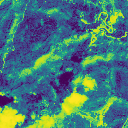
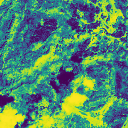
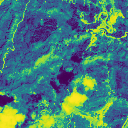
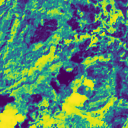
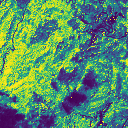
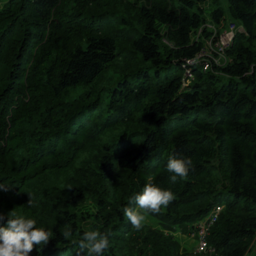
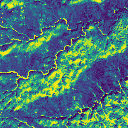
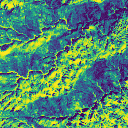
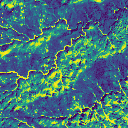
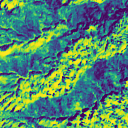
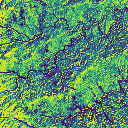
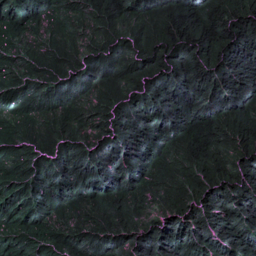
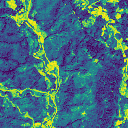
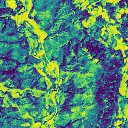
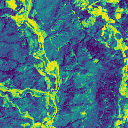
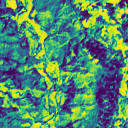
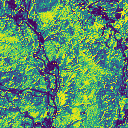
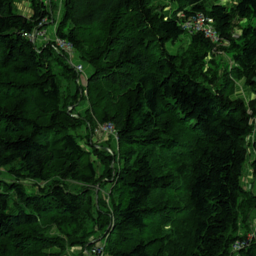
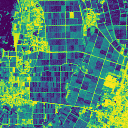
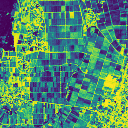
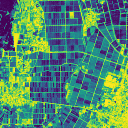
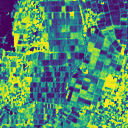
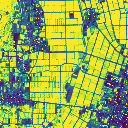
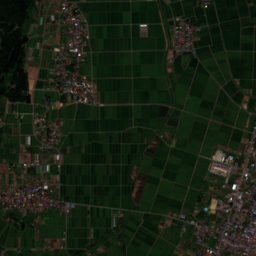
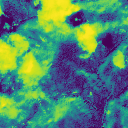
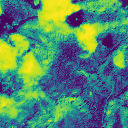
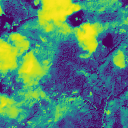
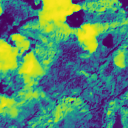
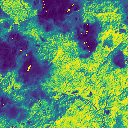
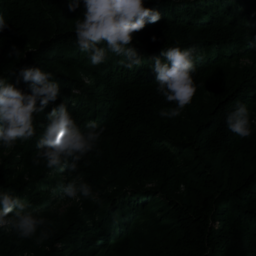

In [0]:
mb.withColumn("rgb", rf_render_png('red', 'green', 'blue'))

## タイルのデータにアクセス

In [0]:
ndvi_df = mb.select('ndvi').take(5)[3].ndvi.tile.cells.data
ndvi_df

Out[31]: array([[0.59313725, 0.59901599, 0.56683168, ..., 0.58938053, 0.57475728,
 0.59488692],
 [0.59901599, 0.59901599, 0.60659898, ..., 0.56309835, 0.56262042,
 0.57935735],
 [0.60048426, 0.60436893, 0.60824742, ..., 0.53910615, 0.60904977,
 0.61050725],
 ...,
 [0.49906074, 0.24622592, 0.17054264, ..., 0.08766234, 0.08389412,
 0.12897196],
 [0.46650999, 0.18070009, 0.12531969, ..., 0.21487603, 0.0662768 ,
 0.15097317],
 [0.35504886, 0.12331233, 0.12340426, ..., 0.18262269, 0.1319193 ,
 0.11803781]])

In [0]:
print(type(ndvi_df))
print(ndvi_df.shape)
print(ndvi_df.ndim)

<class 'numpy.ndarray'>
(256, 256)
2

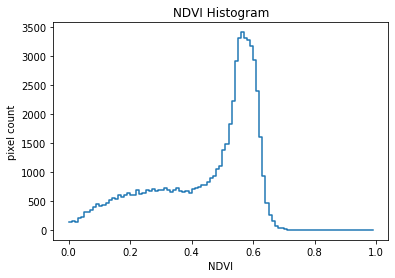

In [0]:
# Calc Histgram of tile
n, bins = np.histogram(ndvi_df, bins=100, range=(0, 1))
plt.figure()
plt.title("NDVI Histogram")
plt.xlabel("NDVI")
plt.ylabel("pixel count")
plt.step(bins[:-1], n, where='post')

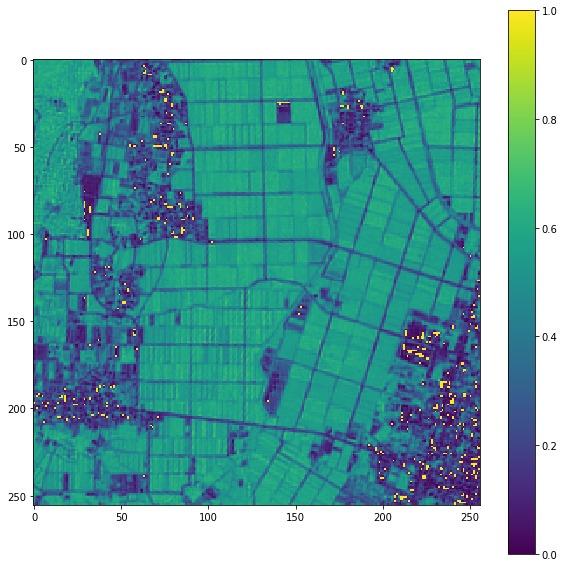

In [0]:
#Show Tile Image
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
cax = ax.imshow(ndvi_df, cmap='viridis', vmin=0, vmax=1)
cbar = fig.colorbar(cax)
plt.show()

## Writing Raster Data
GeoTIFFは、空間データ用の最も一般的なファイル形式の1つで、データのエンコーディング、表現、保存において柔軟性を提供します。RasterFrames は、RasterFrame を GeoTIFF にレンダリングするための特別な Spark DataFrame ライターを提供します。これは、`dataframe.write.geotiff` を呼び出すことによってアクセスされます。

GeoTIFF の欠点として、ビッグデータネイティブフォーマットでないことが挙げられます。GeoTIFF を作成するには、書き込むすべてのデータを Spark ドライバのメモリに収集する必要があります。つまり、書き込むデータのサイズを積極的に制限する必要があるのです。同じ環境で GeoTIFF に書き込むことが実現不可能な入力セットをダラダラと読み込むことは些細なことです。

RasterFrame で GeoTIFF を書き込む場合、収集したデータのサイズを制限する必要があります。データフレームを時間フィルタや空間フィルタによってフィルタリングすることを検討してください。

また、`raster_dimensions` パラメータを使用して、書き込む GeoTIFF ファイルの寸法を指定することができます。`raster_dimensions` パラメータが指定された場合、RasterFrames はバイリニアリサンプリングを使用して分散方式でデータをダウンサンプリングします。指定されない場合、デフォルトはフル解像度でデータフレームを書き込みますが、これは**メモリ不足のエラーになる可能性**があります。

https://rasterframes.io/raster-write.html

In [0]:
outfile = '/dbfs/mnt/testblob/sentinel_ndvi.tif'
mb.select("ndvi").write.geotiff(outfile, crs='EPSG:32654', raster_dimensions=(1024, 1024))